# Trying background subtraction # 

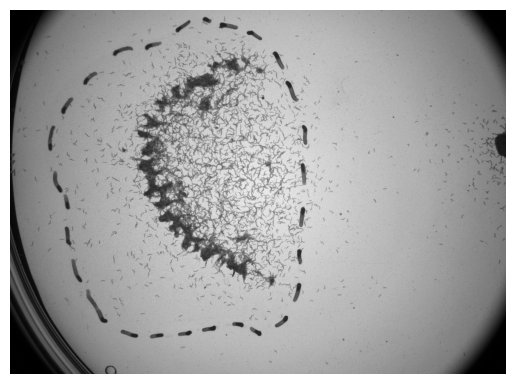

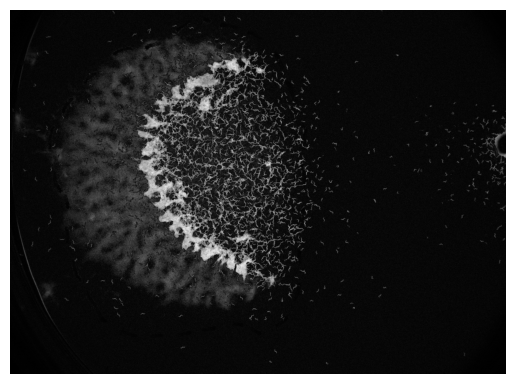

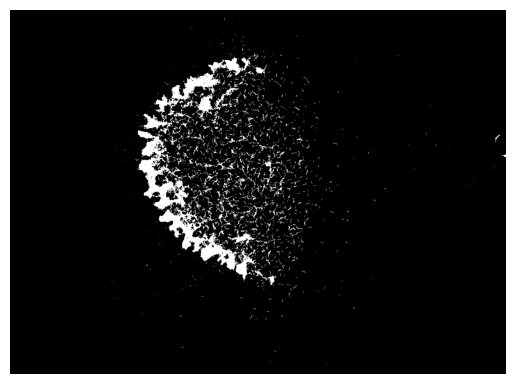

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Specify the directory where the frames are stored
frame_dir = '/Volumes/TOSHIBA_EXT/swarming_surabhi/Experiment-589/Experiment-589'
frame_files = [os.path.join(frame_dir, f) for f in os.listdir(frame_dir) if f.endswith('.tif') and not f.startswith('._')]

# Check if frame_files is not empty
if not frame_files:
    raise ValueError("No frame files found in the specified directory.")

# Sample n images across the video
n = min(50, len(frame_files))  # Use 50 or the number of available frames, whichever is smaller
sampled_frames = np.linspace(0, len(frame_files) - 1, n, dtype=int)

# Load the sampled frames
background_frames = []
for i in sampled_frames:
    img = cv2.imread(frame_files[i], cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise IOError(f"Could not load image {frame_files[i]}")
    background_frames.append(img)

# Check that all images have the same shape
if not all(img.shape == background_frames[0].shape for img in background_frames):
    raise ValueError("Not all images have the same shape.")

# Compute the average of the sampled frames
background_avg = np.mean(background_frames, axis=0).astype(np.uint8)

# Subtract the background from one of the frames for visualization
frame_to_subtract = cv2.imread(frame_files[0], cv2.IMREAD_GRAYSCALE)
background_subtracted = cv2.absdiff(frame_to_subtract, background_avg)

# Plot the frame with the lightest pixels
plt.imshow(background_frames[0], cmap='gray')
# plt.title('Lightest Pixels After Background Subtraction')
plt.axis('off')
plt.show()

# Plot the frame with the background subtracted
plt.imshow(background_subtracted, cmap='gray')
# plt.title('Frame with Background Subtracted')
plt.axis('off')
plt.show()

# Keep only the lightest valued pixels
# You can adjust the threshold value as needed
_, lightest_pixels = cv2.threshold(background_subtracted, 32, 255, cv2.THRESH_BINARY)

# Plot the frame with the lightest pixels
plt.imshow(lightest_pixels, cmap='gray')
# plt.title('Lightest Pixels After Background Subtraction')
plt.axis('off')
plt.show()
